In [40]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import keras
from keras.models import Sequential
from keras.layers import Dense

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder

In [41]:
#Read
df = pd.read_csv('data/movie_new.tsv', delimiter='\t', encoding='ISO-8859-1')


In [42]:
indexes = df[ df['genre'].str.find('Adult') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('News') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Talk-Show') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Game-Show') != -1 ].index
df.drop(indexes, inplace=True)
# indexes = df[ df['genre'].str.find('Short') != -1 ].index
# df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Reality-TV') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Film-Noir') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Musical') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Music') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Documentary') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Biography') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Sport') != -1 ].index
df.drop(indexes, inplace=True)

df['genre'] = df['genre'].str.replace('Short,', '')
df['genre'] = df['genre'].str.replace('Short', '')
df['genre'] = df['genre'].str.replace('Family,', '')
df['genre'] = df['genre'].str.replace('Family', '')
df = df[ df['genre'] != ""]
df['genre'] = df['genre'].str.replace('History', 'War')
df['genre'] = df['genre'].str.replace('Sport', 'Drama')
df['genre'] = df['genre'].str.replace('War', 'Action')
df['genre'] = df['genre'].str.replace('Sci-Fi', 'Fantasy')
df['genre'] = df['genre'].str.replace('Western', 'Action')
df['genre'] = df['genre'].str.replace('Crime', 'Drama')
df['genre'] = df['genre'].str.replace('Mystery', 'Thriller')
#df['genre'] = df['genre'].str.replace('Adventure', 'Action')

In [43]:
ser = pd.Series(df['genre'].str.split(','))
for index, lis in enumerate(ser):
    if lis[len(lis)-1] == "":
        lis = lis[:len(lis)-1]
    ser.iat[index] = pd.unique(lis)[:3]

In [44]:
df['genre'] = ser
df = df[df['genre'].str.len() > 1]
df.head()

,title,genre
6,Camille,"[Drama, Romance]"
21,Cleopatra,"[Drama, Action]"
22,Dante's Inferno,"[Adventure, Drama, Fantasy]"
35,The Last Bohemian,"[Drama, Romance]"
39,The Battle of Gettysburg,"[Drama, Action]"


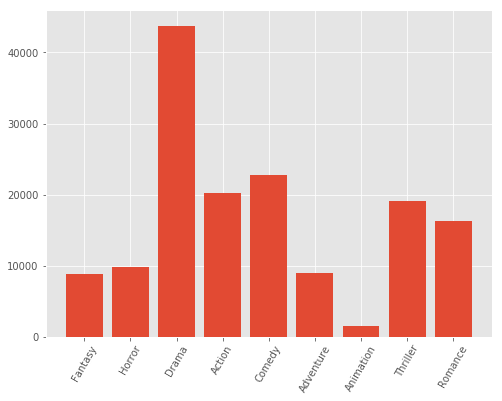

In [45]:
#Majority of movies are comedy, documentary or drama apparently.

fig = plt.figure(figsize=(8,6))
genreC = {}
for genres in df.genre:
    for genre in genres:
        try:
            genreC[genre] = genreC[genre] + 1
        except KeyError:
            genreC[genre] = 0

plt.bar(list(genreC.keys()), list(genreC.values()))
plt.xticks(rotation=60)
plt.show()

In [23]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['top2_acc']
    val_acc = history.history['val_top2_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [46]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding='ISO-8859-1') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [47]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
import io
import json

mlb = MultiLabelBinarizer()
mlb.fit(df.genre)
labels = mlb.classes_
print(labels)

embedding_dim=50
maxlen = 10

num_classes = len(genreC)
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(df.title)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))
    
embedding_matrix = create_embedding_matrix('data/glove.6B.50d.txt', tokenizer.word_index, embedding_dim)

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)

import functools
top2_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=2)

top2_acc.__name__ = 'top2_acc'

def get_features(text_series):
    sequences = tokenizer.texts_to_sequences(text_series)
    return pad_sequences(sequences, maxlen=maxlen)

def prediction_to_label(prediction):
    tag_prob = [(labels[i], prob) for i, prob in enumerate(prediction.tolist())]
    return dict(sorted(tag_prob, key=lambda kv: kv[1], reverse=True))
    
def baseline():
    model = Sequential()
    model.add(Dense(num_classes, input_dim=maxlen, activation='relu'))
    model.add(Dense(num_classes, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[top2_acc])
    return model

def conv1d():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(Conv1D(128, 4, activation='relu', strides=1))
    model.add(GlobalMaxPool1D())
    model.add(Dense(num_classes, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[top2_acc])
    return model

def conv1d_embed():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False))
    model.add(Dropout(0.1))
    model.add(Conv1D(128, 4, activation='relu', strides=1))
    model.add(GlobalMaxPool1D())
    model.add(Dense(num_classes))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[top2_acc])
    return model

def conv1d_embed_train():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
    #model.add(Dropout(0.1))
    model.add(Conv1D(128, 4, activation='relu', strides=1))
    model.add(GlobalMaxPool1D())
    model.add(Dense(num_classes))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[top2_acc])
    return model


['Action' 'Adventure' 'Animation' 'Comedy' 'Drama' 'Fantasy' 'Horror'
 'Romance' 'Thriller']
18318
0.9409324162026422


In [48]:
x = get_features(df.title)
y = mlb.transform(df.genre)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=5000)

In [49]:
countGenres = 0
for genres in df.genre:
    countGenres = countGenres + len(genres)

class_weights = {}
for index, label in enumerate(labels):
    class_weights[index] = countGenres/genreC[label]
    print(label + " " + str(countGenres/genreC[label]))


Action 7.449829890044869
Adventure 16.90233806913525
Animation 103.7706043956044
Comedy 6.6445314217863585
Drama 3.4554602630074327
Fantasy 17.165416950693025
Horror 15.390648874401549
Romance 9.31676635629278
Thriller 7.908400942161737


In [ ]:
model = conv1d_embed_train()
callbacks = [
    #EarlyStopping(patience=3, monitor='val_loss'),
    #ModelCheckpoint(filepath='model_conv1d.h5', save_best_only=True)
]
history = model.fit(x, y,
                    class_weight=class_weights,
                    epochs=20,
                    batch_size=32, verbose=2,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks)
plot_history(history)


Train on 65650 samples, validate on 19695 samples
Epoch 1/20
 - 16s - loss: 4.2365 - top2_acc: 0.5600 - val_loss: 0.4526 - val_top2_acc: 0.5916
Epoch 2/20
 - 16s - loss: 3.8943 - top2_acc: 0.5782 - val_loss: 0.4278 - val_top2_acc: 0.5997
Epoch 3/20
 - 16s - loss: 3.6436 - top2_acc: 0.5959 - val_loss: 0.3999 - val_top2_acc: 0.6479
Epoch 4/20
 - 16s - loss: 3.3933 - top2_acc: 0.6157 - val_loss: 0.3848 - val_top2_acc: 0.6535
Epoch 5/20
 - 16s - loss: 3.1623 - top2_acc: 0.6340 - val_loss: 0.3594 - val_top2_acc: 0.6660
Epoch 6/20
 - 16s - loss: 2.9472 - top2_acc: 0.6484 - val_loss: 0.3429 - val_top2_acc: 0.6797
Epoch 7/20
 - 16s - loss: 2.7530 - top2_acc: 0.6627 - val_loss: 0.3245 - val_top2_acc: 0.6975
Epoch 8/20
 - 17s - loss: 2.5833 - top2_acc: 0.6756 - val_loss: 0.3057 - val_top2_acc: 0.6976
Epoch 9/20
 - 17s - loss: 2.4365 - top2_acc: 0.6853 - val_loss: 0.2962 - val_top2_acc: 0.6928
Epoch 10/20
 - 16s - loss: 2.3115 - top2_acc: 0.6965 - val_loss: 0.2817 - val_top2_acc: 0.7248
Epoch 11/

In [60]:
#conv1d_model = keras.models.load_model('model_conv1d_test.h5')
#print(model.evaluate(x_test, y_test))


f = get_features(["Wreck-It Ralph"])
print(f)
p1 = prediction_to_label(model.predict(f)[0])
# p2 = prediction_to_label(modelEmb.predict(f)[0])
# p3 = prediction_to_label(modelEmbTrain.predict(f)[0])
top1 = max(p1, key=p1.get)
del p1[top1]
top2 = max(p1, key=p1.get)
del p1[top2]
top3 = max(p1, key=p1.get)
print(top1)
print(top2)
print(top3)
# df_t = pd.DataFrame()
# df_t['label'] = p1.keys()
# df_t['p_conv'] = p1.values()
# df_t.sort_values(by='p_conv', ascending=False)

[[   0    0    0    0    0    0    0 4771   38 5255]]
Drama
Comedy
Adventure


In [61]:
model.save('model_conv_new.h5')